In [2]:
import numpy as np
import pandas as pd
import os, time
from itertools import product

from pandas import read_csv, Series, DataFrame

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.style.use('fivethirtyeight')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/dkhosla/miniconda3/envs/ds-py3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 5

# Exploratory Time Series Analysis 
---

### 1. Make Plots

* Line Chart to visualize trend, presence of seasonality/noise/outliers etc.
* Histogram to visualize the distribution of values
* Resampled Time Series for long-term overall trends
* Box-plots to estimate seasonality effects
* ACF, PACF plots to examine autocorrelation and partial autocorrelation and estimate *p, q* for ARIMA
* Scatterplot matrix on lags to visualize autocorrelation of the series

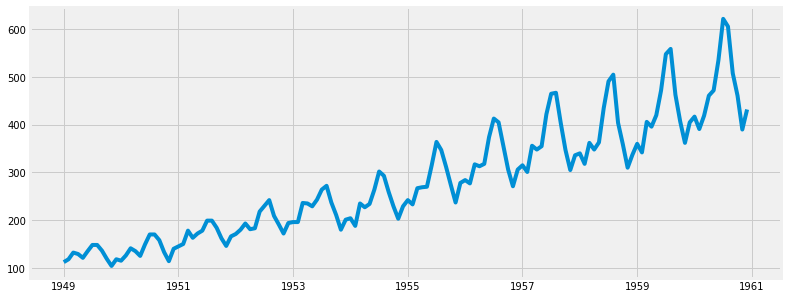

In [29]:
df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/datasets/AirPassengers.csv")

y = pd.Series(data=df['value'].values, 
              index=pd.date_range(start='1949-01-01', periods=len(df), freq='MS'))
y.name = 'n_pass_thousands'
y.plot();

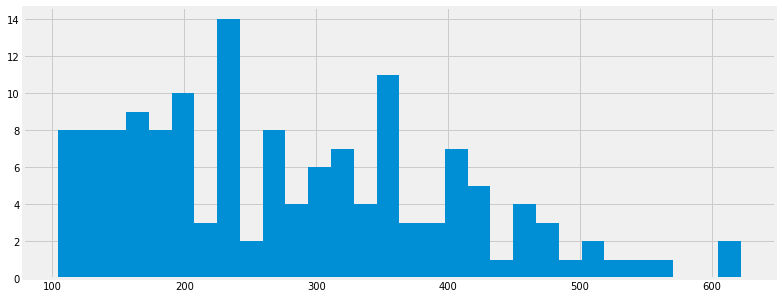

In [11]:
y.hist(bins=30);

### Examine Trend

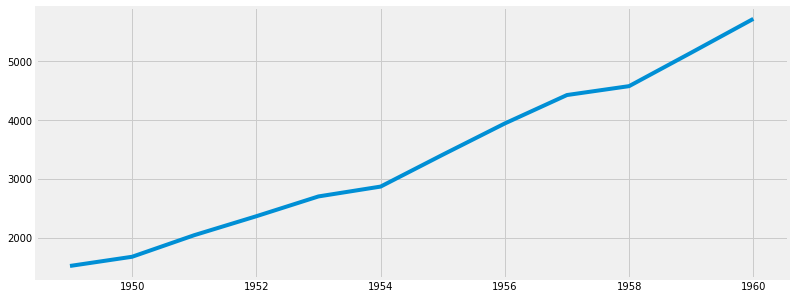

In [12]:
y.resample('AS').sum().plot();

### Examine Seasonality

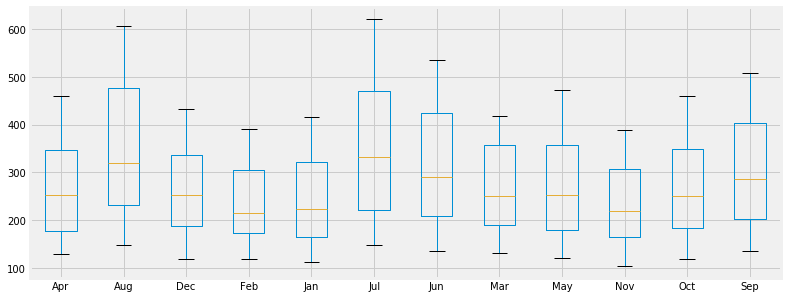

In [21]:
(y
 .reset_index()
 .assign(Month = lambda df: pd.to_datetime(df['index']).dt.strftime('%b'),
         Year = lambda df: pd.to_datetime(df['index']).dt.year)
 .pivot(index='Year', columns='Month', values=0)
 .plot.box()
);

### Decompose for Trend and Seasonality

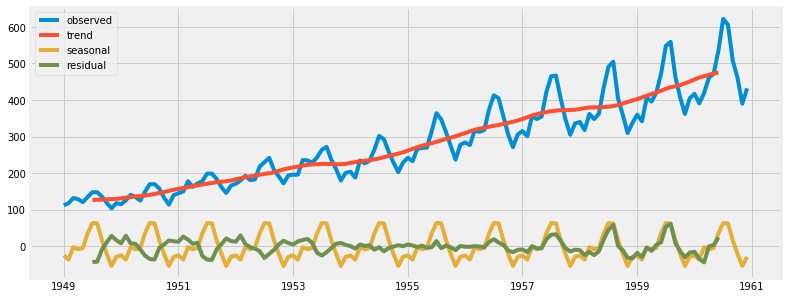

In [25]:
def ts_decompose(ts):
    """
    Produce plots of a ts decomposed into components
    """
    decomposed_ts = seasonal_decompose(ts)  
    decomposed_df = pd.DataFrame({'observed': decomposed_ts.observed,
                                  'trend':  decomposed_ts.trend,
                                  'seasonal': decomposed_ts.seasonal, 
                                  'residual': decomposed_ts.resid})
    return decomposed_df[['observed', 'trend', 'seasonal', 'residual']]

ts_decompose(y).plot();

### Visualize Autocorrelation via Scatterplots

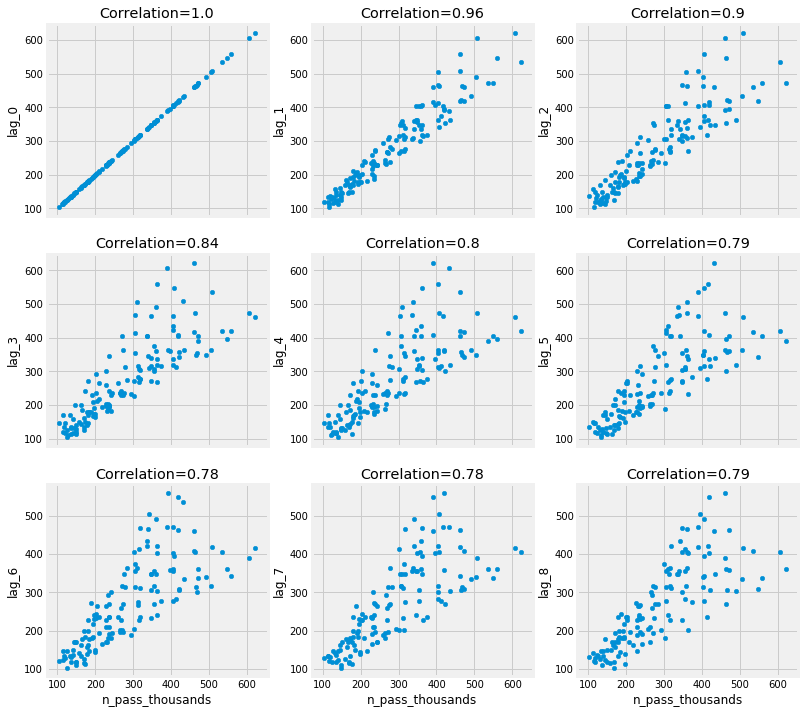

In [39]:
df = y.to_frame().copy()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True)

for lag, ax in enumerate([(x, y) for x in range(3) for y in range(3)]):
    df['lag_{}'.format(lag)] = df['n_pass_thousands'].shift(lag)
    corr = round(df[['n_pass_thousands', 'lag_{}'.format(lag)]].corr().iloc[0].iloc[1], 2)
    df.plot.scatter(x='n_pass_thousands', y='lag_{}'.format(lag), 
                    ax=axes[ax[0], ax[1]], title='Correlation={}'.format(corr))

### Examine Stationarity with ADF tests

In [43]:
def stationarity(ts=Series(), w=12):
    """
    Produce plot of rolling mean, stddev
    Results of the Dickey-Fuller Test
    """

    sdf = pd.DataFrame({'Actual': ts,
                        'Means': ts.rolling(window=w, center=False).mean(),
                        'Stddevs': ts.rolling(window=w, center=False).std()
                       }, index=ts.index)

    test_df = adfuller(ts, autolag='AIC')
    result = pd.concat([pd.Series(test_df[:4], 
                                  index=['stat', 'pval', 'lags', 'numobs']),
                        pd.Series(test_df[4])])
    print("Dickey-Fuller Test Results")
    print(result)
    sdf.plot()
    return None

Dickey-Fuller Test Results
stat        0.815369
pval        0.991880
lags       13.000000
numobs    130.000000
1%         -3.481682
10%        -2.578770
5%         -2.884042
dtype: float64


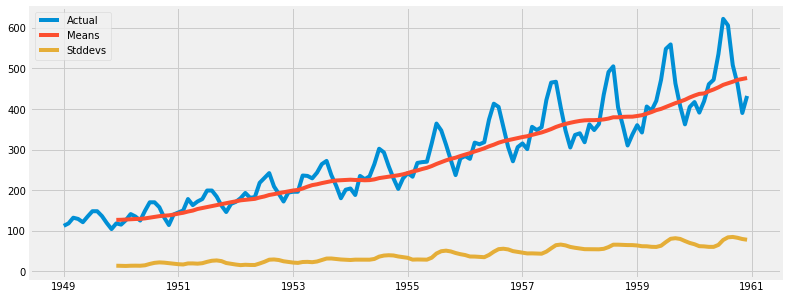

In [44]:
stationarity(ts=y)

### Examine AutoCorrelation

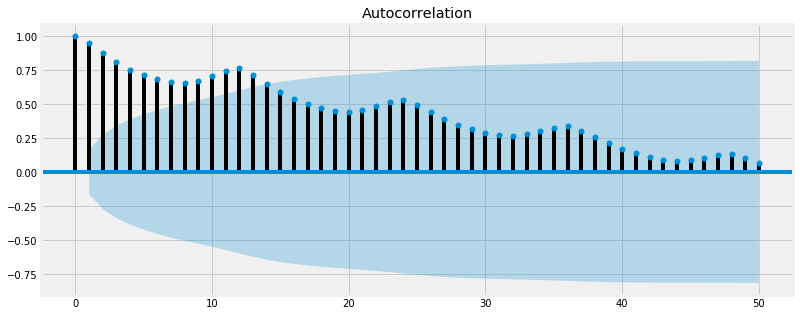

In [45]:
plot_acf(y, lags=50);

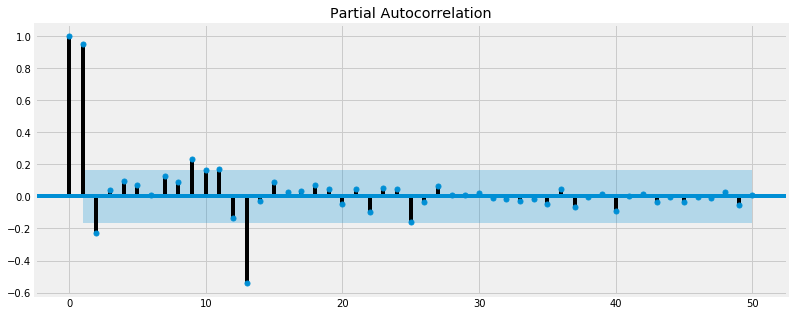

In [46]:
plot_pacf(y, lags=50);

# Box-Jenkins Approach to Non-Seasonal ARIMA Modeling

---

<big>

1. Assess the stationarity of the process $z_t$
2. If the process is not stationary, difference it (i.e. create an integrated model) as many times as needed to produced a stationary process to be modeled using the $\textit{mixed autoregressive-moving average process}$.
3. Identify (i.e. determining the order of the process) the resulting the ARMA model.
  * The sample autocorrelation and sample partial autocorrelation functions are tools used in step $1$ and $2$.

In practice, other steps are necessary in order to produce a functionable model. 

These steps include:

- Model diagnostic checking
- Re-specification of the model if one or more of the underlying statistical assumptions is not satisfied
- Model selection
- Perform statistical inference and/or forecasting
- Forecast evaluation

---

### Model Identification (ARIMA Model Determination)

1. Determine the *degree of differencing*, $d$

2. Study the patterns of the ACF and PACF of the appropriately differenced series, as these autocorrelation functions will provide indication for the choice of the order of autoregressive and the moving average components. 

3. The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

---

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |


> In general, the ACF of an autoregressive process is similar to the PACF of a moving average process, and vice versa.

5. Keep in mind that these are theoretical properties. In practice, the estimated sample ACF and PACF can come with large variances, deviating from the underlying theoretical behavior. As such, it is prudent to recognize that these are  but broad characteristics, and it is quite possible that several candidate models are narrowed down and will need to be investigaged further in the later stage of the modeling process.

---

### Automated Selection of $p, q$


    train_results = sm.tsa.arma_order_select_ic(tr, ic=['aic', 'bic'], trend='nc', 
                                                max_ar=4, max_ma=4)
    print('AIC', train_results.aic_min_order)
    print('BIC', train_results.bic_min_order)
    
    
---

### Model Diagnostic Checking

* Conduct visual inspection of the **residual plots**
    * Residuals of a well-specified ARIMA model should mimic *Gaussian white noises*: the residuals should be uncorrelated and distributed approximated normally with mean zero and variance $n^{-1}$
    * Apparent patterns in the standardized residuals and the estimated ACF of the residuals give an indication that the model need to be re-specified

> The `results.plot_diagnostics()` function conveniently produce several plots to facilitate the investigation.

In [ ]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)